# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import DataScienceHelperLibrary as dsh
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
import numpy as np
import pandas as pd
import re
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sqlalchemy import create_engine

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data from database
database = 'MyDisasterResponse.db'
table = 'MyMessage'

engine = create_engine('sqlite:///{}'.format(database))

df = pd.read_sql_table(table, engine)

In [3]:
dsh.AnalyzeDataFrame(df)

-------------------- Dataframe analysis started --------------------
Shape:  (22621, 41)
Number of duplicate rows:  0
-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 40, 97.56%
index, type: int64                     0.0
id, type: int64                        0.0
message, type: object                  0.0
genre, type: object                    0.0
related, type: int64                   0.0
request, type: int64                   0.0
offer, type: int64                     0.0
aid_related, type: int64               0.0
medical_help, type: int64              0.0
medical_products, type: int64          0.0
search_and_rescue, type: int64         0.0
security, type: int64                  0.0
military, type: int64                  0.0
child_alone, type: int64               0.0
water, type: int64                     0.0
food, type: int64                      0.0
shelter, type: int64                   0.0
clothing, type: int64              

Hmm... there were nan values that have been inserted into database...

In [4]:
df[df.original == np.nan]

,index,id,message,original,genre,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report


Hmmm.... there were definitely missing values...

In [5]:
type(df.at[7408, 'original']) # example ID I radonmly found.

NoneType

In [6]:
df[df.original == None]

,index,id,message,original,genre,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report


In [7]:
type(None)

NoneType

Hmmm.... I thought that None or np.nan would be interpretet as something like DBNULL. Instead it is a string value?! I didn't calculated that...

In [8]:
df[df.original == 'NoneType']

,index,id,message,original,genre,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report


I give up... I thought there is an adequate handling for np.nan und database NULL values. I just intended to check the number of mising values before and after writing into database. But as you can see, currently I'm out of ideas how to do it ...

## Remark: Dropping rows before modeling

As I mentioned at ETL 7.0, I didn't drop rows that were irrelevant because its possible that irrelevant rows have been added before selecting the data from database. 

So here at this step the data needs to be cleaned either way. My following steps:
- remove column 'original' as there are many missing values as explored during ETL and cannot be proven here as you can see above ^^
- remove rows when message starts with 'NOTES:'
- remove rows with related not in [0, 1]



In [9]:
df = dsh.RemoveColumnsByWildcard(df, 'original')

-------------------- Start finding and removing columns matchting to wildcards: ['original'] --------------------
Columns found to remove:  ['original']
-------------------- Finished removing columns matchting to wildcards --------------------


In [10]:
df[df['message'].str.startswith('NOTES:')]

,index,id,message,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
3062,3083,3539,NOTES: Personal. Not an emergency.,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3095,3116,3579,NOTES: aclet dry We are counting on you.,direct,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3099,3120,3583,NOTES: talking about gas prices,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3162,3183,3651,NOTES: Historic earthquake in Haiti.,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3236,3257,3737,NOTES: They are requesting that somebody to pa...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3258,3279,3761,NOTES: Regular gossip or message sharing. Not ...,direct,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3268,3289,3775,NOTES: personal request. Not an emergency.,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3311,3332,3820,NOTES: regular gossip. Not an emergency.,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3357,3378,3871,NOTES: Gossip. Not an emergency.,direct,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3362,3383,3877,NOTES: Personal comment. Not an emergency.,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Remove messages starting with 'NOTES:'

df = dsh.RemoveRowsWithValueInColumn(df, 'message', ['NOTES:'], option = 'startswith')

329 rows (ca. 1.45%) have been removed having value/s "['NOTES:']" in column "message"


In [12]:
# Just keep messages with related = 0 or 1 (drop 2 or potentially other values)

df = dsh.SelectRowsWithValueInColumn(df, 'related', [0, 1])

165 rows (ca. 0.73%) have been removed not having value/s "[0, 1]" in column "related"


In [13]:
dfcopy = df.copy(deep = True)

In [14]:
df = dfcopy.copy(deep = True)

## Now: Splitting data

In [15]:
X = dsh.SelectColumnsByWildcard(df, ['message'])

Y = dsh.RemoveColumnsByWildcard(df, ['index', 'id', 'message', 'original', 'genre'])

-------------------- Start finding and keeping columns matchting to wildcards: ['message'] --------------------
-------------------- Finished keeping columns matchting to wildcards: 1 --------------------
-------------------- Start finding and removing columns matchting to wildcards: ['index', 'id', 'message', 'original', 'genre'] --------------------
Columns found to remove:  ['index', 'id', 'message', 'genre']
-------------------- Finished removing columns matchting to wildcards --------------------


### 2. Write a tokenization function to process your text data

In [16]:
# 
regUrl = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
regChars = r'[^a-zA-Z0-9]'

supportedLanguages = [
    'english', 
#    'frensh'
]

def Tokenize(text):
    
    text = text.lower()
    
    foundUrls = re.findall(regUrl, text)
    for url in foundUrls:
        text = text.replace(url, "urlplaceholder")
    
    tokens = word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()
    
    cleanTokens = []
    for tok in tokens:
        
        if not tok.isalpha():
            continue
        
        cleanTok = lemmatizer.lemmatize(tok).strip()
        #cleanTok = [PorterStemmer().stem(tok) for tok in cleanTok]
        
        try:
            for lang in supportedLanguages:
                if cleanTok in stopwords.words(lang):
                    continue
        except:
            print('Error during stop word handling with language: ', lang, \
                '\nand token: ', tok)
        
        if len(cleanTok) > 1:
            cleanTokens.append(cleanTok)
    
    return cleanTokens
        
        

### 3. Build a machine learning pipeline
- You'll find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [17]:
# pipeline = Pipeline([
#         ('features', FeatureUnion([

#             ('text_pipeline', Pipeline([
#                 ('vect', CountVectorizer(tokenizer = Tokenize)),
#                 ('tfidf', TfidfTransformer())
#             ])),

#             #('starting_verb', StartingVerbExtractor())
#         ])),

#         ('clf', MultiOutputClassifier())
#     ])


_cv = CountVectorizer(tokenizer = Tokenize)
_tfidf = TfidfTransformer()
_classifierInner = RandomForestClassifier(n_estimators = Y.shape[1], random_state = 42)
_classifierOuter = MultiOutputClassifier(_classifierInner, n_jobs = 4)


pipeline = Pipeline([('vect', _cv),
                     ('tfidf', _tfidf),
                     ('clf', _classifierOuter,)
                    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [18]:
XTrain, XTest, yTrain, yTest = dsh.SplitDataTrainTest(X, Y)

In [19]:
print(XTrain.shape)
print(XTest.shape)
print(yTrain.shape)
print(yTest.shape)

(15719, 1)
(6737, 1)
(15719, 36)
(6737, 36)


XTrain.values

In [20]:
_ser = XTrain['message']
print(type(_ser.values))

<class 'numpy.ndarray'>


In [21]:
xFitTrans = pipeline.fit(_ser.values, yTrain.values)

In [22]:
yPred = xFitTrans.predict(XTest['message'].values)

In [23]:
#print(XTest.at[0, 'message'])
#print(yPred.)

In [24]:
#print(yTest)
print(yPred.shape, type(yPred))

(6737, 36) <class 'numpy.ndarray'>


In [25]:
print(yTest.shape, type(yTest.values))

(6737, 36) <class 'numpy.ndarray'>


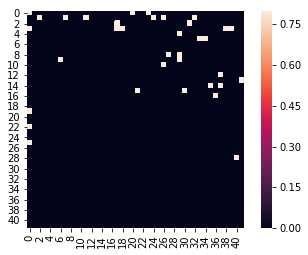

In [36]:
sns.heatmap(confusion_matrix(yTest.values.argmax(axis=0), yPred.argmax(axis=0)), vmax = 0.8, square = True)

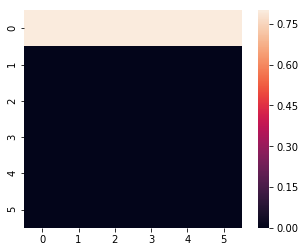

In [37]:
sns.heatmap(confusion_matrix(yTest.values.argmax(axis=1), yPred.argmax(axis=1)), vmax = 0.8, square = True)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
from sklearn.metrics import classification_report



### 6. Improve your model
Use grid search to find better parameters. 

In [65]:
_classifierOuter.get_params()

{'estimator__bootstrap': True,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 36,
 'estimator__n_jobs': 1,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=36, n_jobs=1,
             oob_score=False, random_state=42, verbose=0, warm_start=Fa

In [72]:


parameters = {
       # 'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
       # 'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
       # 'features__text_pipeline__vect__max_features': (None, 5000, 10000),
       # 'features__text_pipeline__tfidf__use_idf': (True, False),
      #  'clf__estimators': [RandomForestClassifier(10)],
      #  'clf__min_samples_split': [2, 3, 4],
      #  'features__transformer_weights': (
      #      {'text_pipeline': 1, 'starting_verb': 0.5},
      #      {'text_pipeline': 0.5, 'starting_verb': 1},
      #      {'text_pipeline': 0.8, 'starting_verb': 1},
      #  )
    
      #"classifier__max_depth": [3, None],
      #        "classifier__max_features": [1, 3, 10],
      #        "classifier__min_samples_split": [1, 3, 10],
      #        "classifier__min_samples_leaf": [1, 3, 10],
      #        # "bootstrap": [True, False],
      #        "classifier__criterion": ["gini", "entropy"]

    "features__text_pipeline__clf_estimator" : [_classifierInner, AdaBoostClassifier()]
    
    }


parameters = _classifierOuter.get_params()

cv = GridSearchCV(pipeline, param_grid = parameters)

ValueError: Parameter values for parameter (estimator__bootstrap) need to be a sequence(but not a string) or np.ndarray.

In [71]:
cv.fit(XTrain['message'].values, yTrain.values)

ValueError: Invalid parameter classifier for estimator Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_jobs=1))]). Check the list of available parameters with `estimator.get_params().keys()`.

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.